In [1]:
import json, os
import matplotlib.pyplot as plt
import numpy as np

In [110]:
data = os.popen('../build/tann test greedy-net ../datasets/siftsmall-128-euclidean.hdf5').read()
data = np.array(json.loads(data))

Try to read /test [I16]... --> size: 100x128
Try to read /train [I16]... --> size: 10000x128
[Linear Search]
Build time: 51 ns
Query time: 17613533 ns
[Greedy Net, shard_count=1] => build time: 1518825523 ns
[Greedy Net, shard_count=2] => build time: 1509209118 ns
[Greedy Net, shard_count=3] => build time: 1549346816 ns
[Greedy Net, shard_count=4] => build time: 1568400937 ns
[Greedy Net, shard_count=5] => build time: 1548934405 ns
[Greedy Net, shard_count=6] => build time: 1528544456 ns
[Greedy Net, shard_count=7] => build time: 1535090087 ns
[Greedy Net, shard_count=8] => build time: 1570560862 ns
[Greedy Net, shard_count=9] => build time: 1508487276 ns
[Greedy Net, shard_count=10] => build time: 1515445003 ns
[Greedy Net, shard_count=11] => build time: 1511866814 ns
[Greedy Net, shard_count=12] => build time: 1512413234 ns
[Greedy Net, shard_count=13] => build time: 1563317391 ns
[Greedy Net, shard_count=14] => build time: 1551244065 ns
[Greedy Net, shard_count=15] => build time: 15

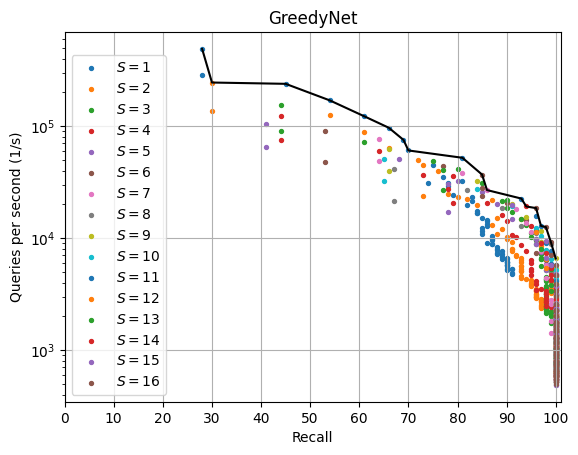

In [111]:
n = data.shape[0]
SC = data[:,0]
QPS = data[:,2]
RECALL = data[:,3]
# plt.scatter(RECALL[SC==1], QPS[SC==1], c='red', alpha=0.2, label="S=1")
# plt.scatter(RECALL[SC==2], QPS[SC==2], c='orange', alpha=0.2, label="S=2")
# plt.scatter(RECALL[SC==5], QPS[SC==5], c='blue', alpha=0.2, label="S=5")
# plt.scatter(RECALL[SC==6], QPS[SC==6], c='green', alpha=0.2, label="S=6")
# plt.scatter(RECALL[SC==7], QPS[SC==7], c='purple', alpha=0.2, label="S=7")
for i in range(1, 17):
    plt.scatter(RECALL[SC==i], QPS[SC==i], alpha=1, label=f"$S={i}$", s=8)
plt.xlim(0, 101)
plt.yscale('log')

best_data = []
for i in range(n):
    best = True
    for j in range(n):
        if (QPS[j] > QPS[i]) and (RECALL[j] >= RECALL[i]):
            best = False
            break
    if best:
        best_data.append(data[i])
best_data.sort(key = lambda row: row[3])
best_data = np.array(best_data)
plt.plot(best_data[:,3], best_data[:,2], color='black')
plt.xlabel('Recall')
plt.xticks(np.linspace(0, 100, 11))
plt.ylabel('Queries per second (1/s)')
plt.title('GreedyNet')
plt.grid()
plt.legend(loc='lower left')

plt.show()

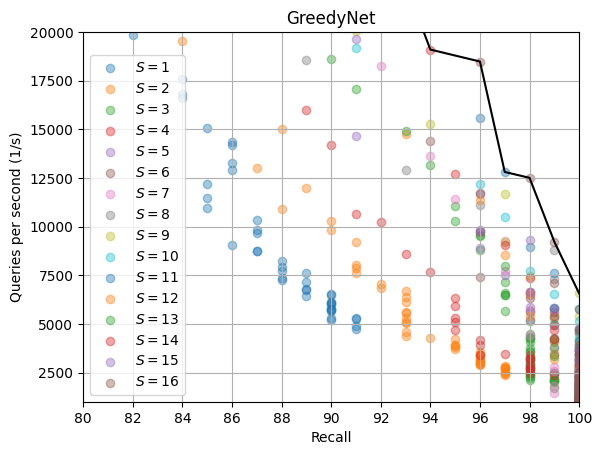

In [112]:
n = data.shape[0]
SC = data[data[:,1] < 2000,0]
QPS = data[data[:,1] < 2000,2]
RECALL = data[data[:,1] < 2000,3]
n = SC.shape[0]
# plt.scatter(RECALL[SC==6], QPS[SC==6], c='red', alpha=0.4, label="S=6")
# plt.scatter(RECALL[SC==7], QPS[SC==7], c='orange', alpha=0.4, label="S=7")
# plt.scatter(RECALL[SC==9], QPS[SC==9], c='blue', alpha=0.4, label="S=9")
# plt.scatter(RECALL[SC==10], QPS[SC==10], c='green', alpha=0.4, label="S=10")
# plt.scatter(RECALL[SC==11], QPS[SC==11], c='purple', alpha=0.4, label="S=11")
for i in range(1, 17):
    plt.scatter(RECALL[SC==i], QPS[SC==i], alpha=0.4, label=f"$S={i}$")
plt.xlim(80, 100)
plt.ylim(10**3, 20000)
# plt.yscale('log')

best_data = []
for i in range(n):
    best = True
    for j in range(n):
        if (QPS[j] > QPS[i]) and (RECALL[j] >= RECALL[i]):
            best = False
            break
    if best:
        best_data.append(data[i])
best_data.sort(key = lambda row: row[3])
best_data = np.array(best_data)
plt.plot(best_data[:,3], best_data[:,2], color='black')
plt.xlabel('Recall')
plt.ylabel('Queries per second (1/s)')
plt.title('GreedyNet')

plt.xticks(np.linspace(80, 100, 11))

plt.grid()
plt.legend()

plt.show()

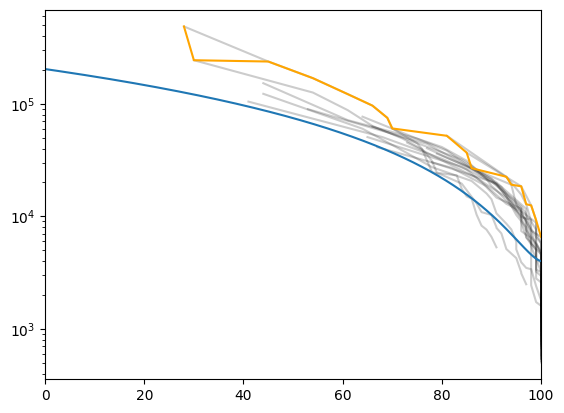

In [113]:
def GetBest(data):
    best_data = []
    n = data.shape[0]
    for i in range(n):
        best = True
        for j in range(n):
            if (QPS[j] > QPS[i]) and (RECALL[j] >= RECALL[i]):
                best = False
                break
        if best:
            best_data.append(data[i])
    best_data.sort(key = lambda row: row[3])
    best_data = np.array(best_data)
    return best_data

for i in range(1, 17):
    cur = GetBest(data[data[:,0] == i])
    plt.plot(cur[:,3], cur[:,2], alpha=0.2, color='black')
cur = GetBest(data)
plt.plot(cur[:,3], cur[:,2], color='orange')
plt.yscale('log')
X = np.linspace(0, 1, 1000)
plt.plot(100*(1-X), (X**1.5) * 2e5 + 4e3)
plt.xlim(0, 100)
plt.show()

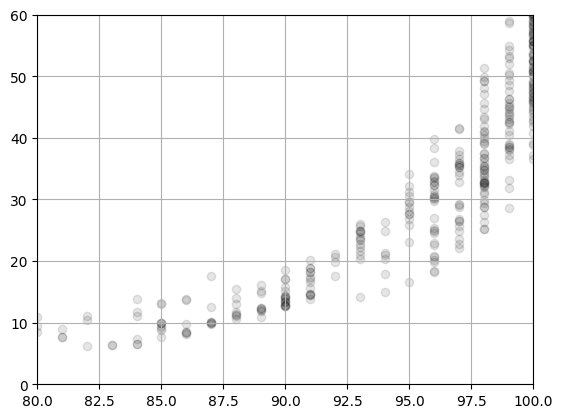

In [114]:
RECALL = data[:,3]
CMPCNT = data[:,4]
plt.scatter(RECALL, CMPCNT, c='black', alpha=0.1)
plt.xlim(80, 100)
plt.ylim(0, 60)
plt.grid()
plt.show()

In [75]:
import hnswlib, h5py, time


In [77]:
with h5py.File('../datasets/siftsmall-128-euclidean.hdf5') as f:
    data_train = np.array(f['train'])
    data_test = np.array(f['test'])
n,dim = data_train.shape
p = hnswlib.Index(space='l2', dim=dim)
p.init_index(max_elements=n, ef_construction=200, M=32)
p.add_items(data_train, np.arange(n))

In [83]:
ans = []
for i in range(data_test.shape[0]):
    q = data_test[i]
    min_dist = -1
    for j in range(n):
        cur_dist = np.sum((data_train[j] - q)**2)
        if min_dist == -1 or cur_dist < min_dist:
            min_dist = cur_dist
    ans.append(min_dist)
print(len(ans))

100


In [99]:
p.set_ef(50)
_, distances = p.knn_query(data_test)
distances = distances.reshape(data_test.shape[0])

runs = []
for ef in range(1, 100):
    t1 = time.time_ns()
    _, distances = p.knn_query(data_test, k=1, num_threads=1)
    t2 = time.time_ns()
    distances.reshape(data_test.shape[0])
    distances = np.squeeze(distances)
    ans = np.array(ans)
    recall = np.sum(np.where(distances <= np.array(ans), 1, 0))
    runs.append([10**9 / (t2-t1) * data_test.shape[0], 
                 recall * 100 / data_test.shape[0]])
runs = np.array(runs)

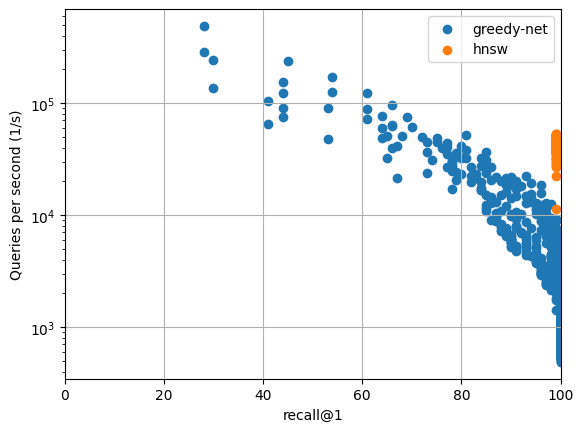

In [117]:
plt.scatter(data[:,3], data[:,2], label='greedy-net')
plt.scatter(runs[:,1], runs[:,0], label='hnsw')
plt.xlim(0, 100)
plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel('recall@1')
plt.ylabel('Queries per second (1/s)')
plt.show()